In [77]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

with open('/Users/michaelbeavitt/Documents/mooney_files/data/web-app/master_df.pickle', 'rb') as f:
    master_df = pickle.load(f)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

def resolve_duplicate_columns(df):
    cols = pd.Series(df.columns)
    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
    df.columns = cols
    return df

master_df = resolve_duplicate_columns(master_df)

Index(['days_after_start', 'C5a (BR18) (18)', 'LBP(BR57) (57)', '2-# FITC+_1',
       '1-# FITC+_1', 'IL-1b/IL-1F2 (BR57) (57)', 'nts_netosis', 'lps_netosis',
       '1-FoP_1', 'IL-12/IL-23p40 (BR67) (67)', 'TNFa (BR12) (12)',
       '2-%FITC-_1', '2-%FITC+_1', '2-%ROS-hi_1', 'ros comparison 1', '2-FoP',
       'PMA_killing', 'IFNa (BR63) (63)', '2-FoP_1', 'IL-4 (BR39) (39)'],
      dtype='object')


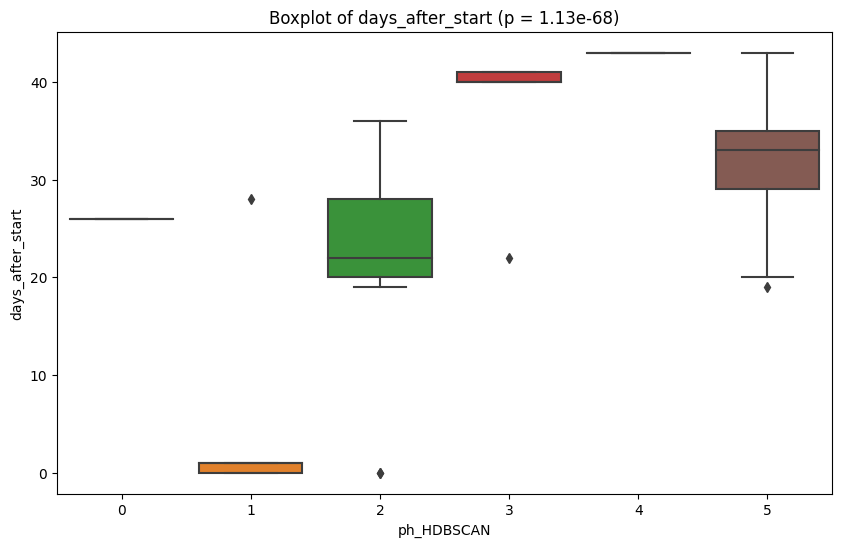

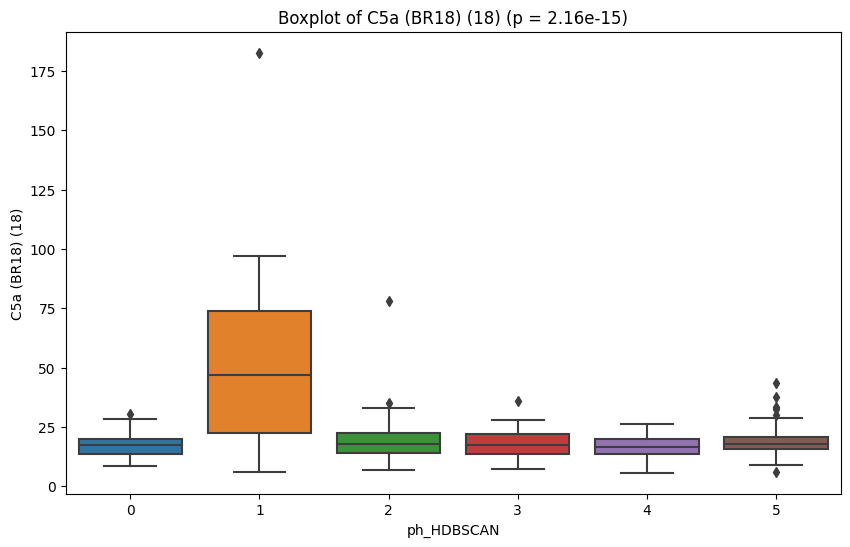

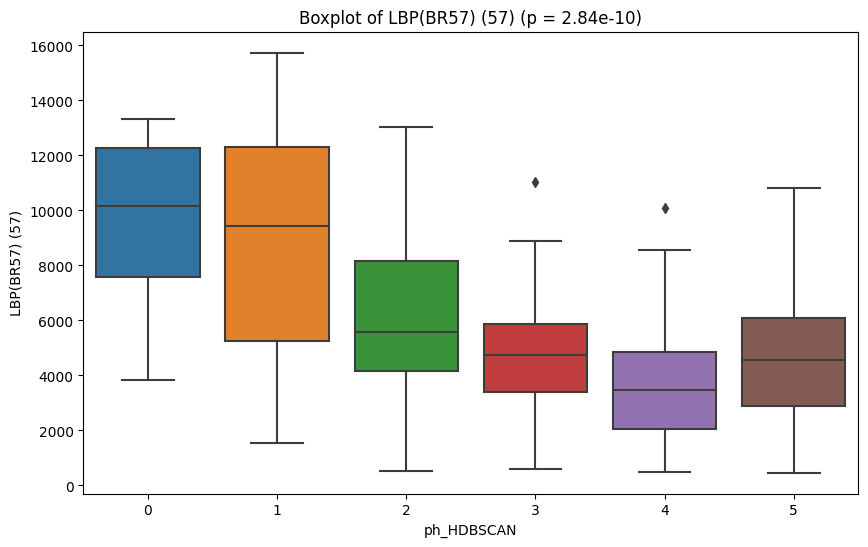

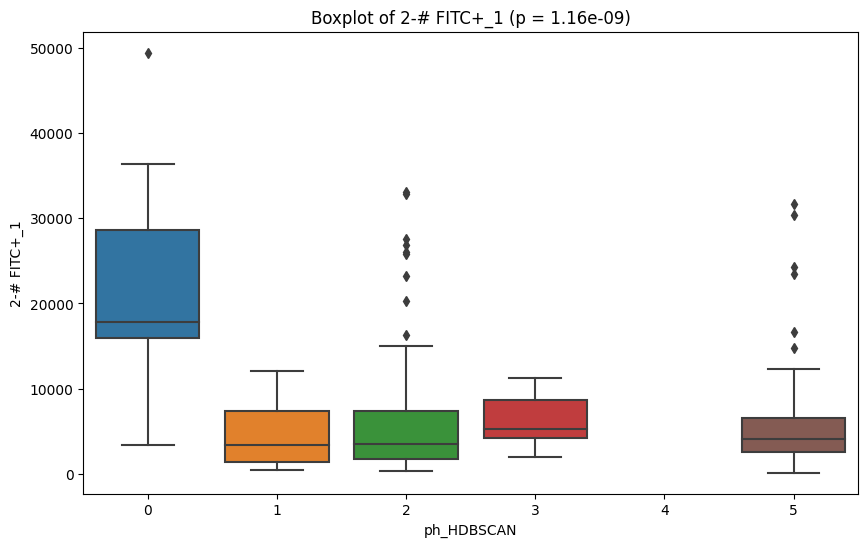

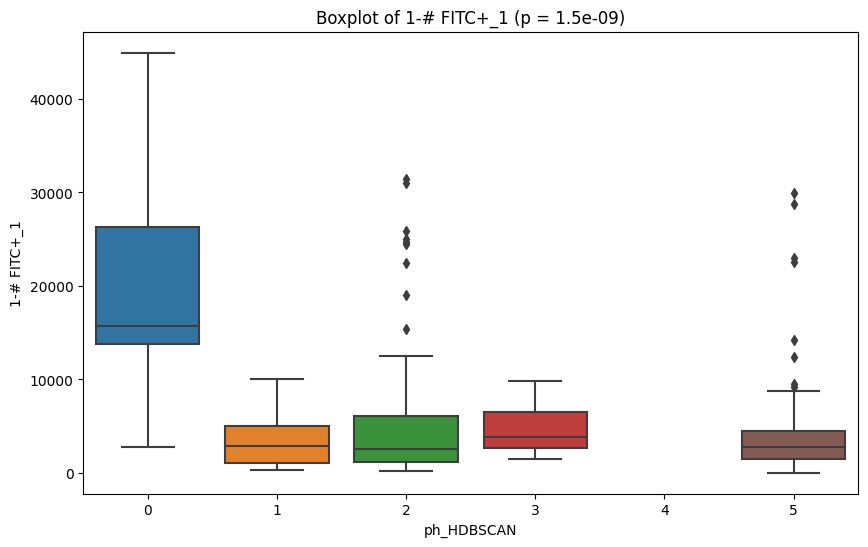

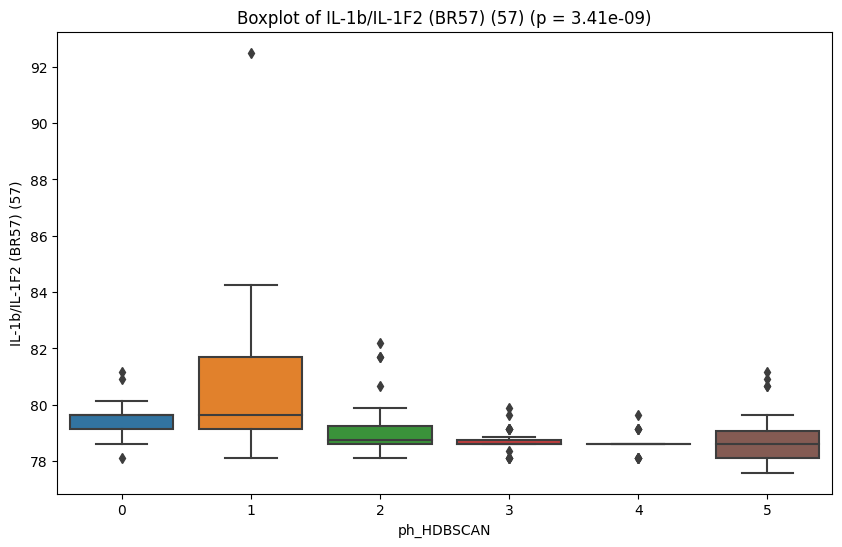

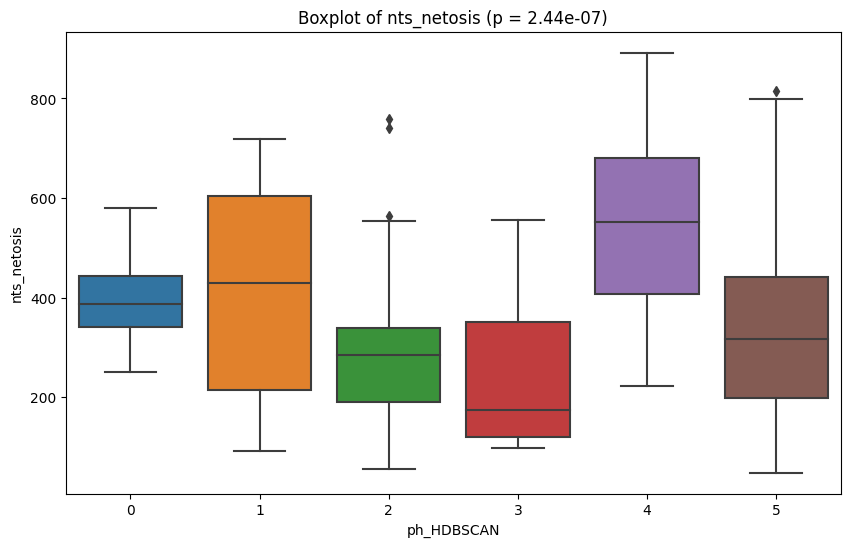

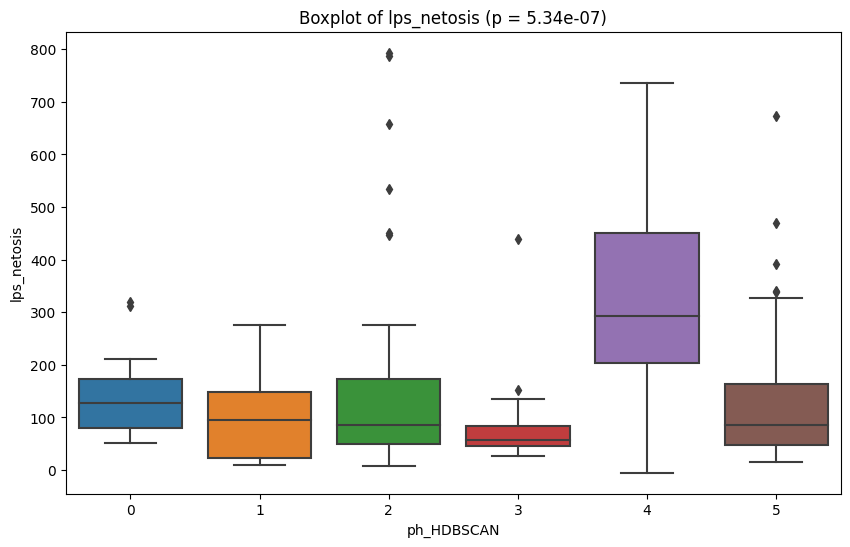

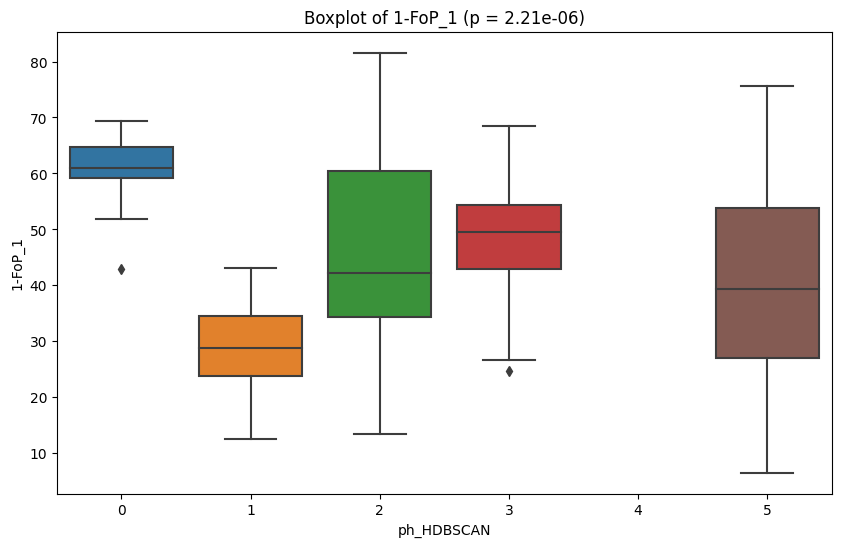

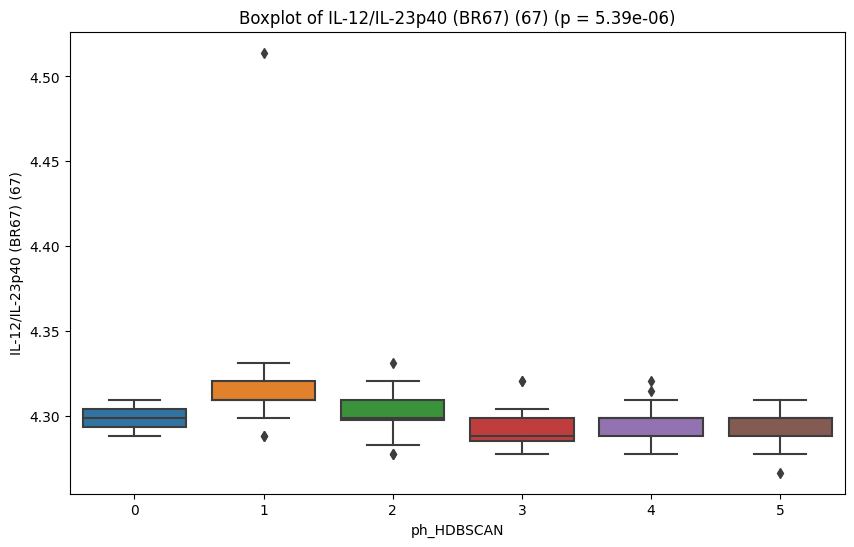

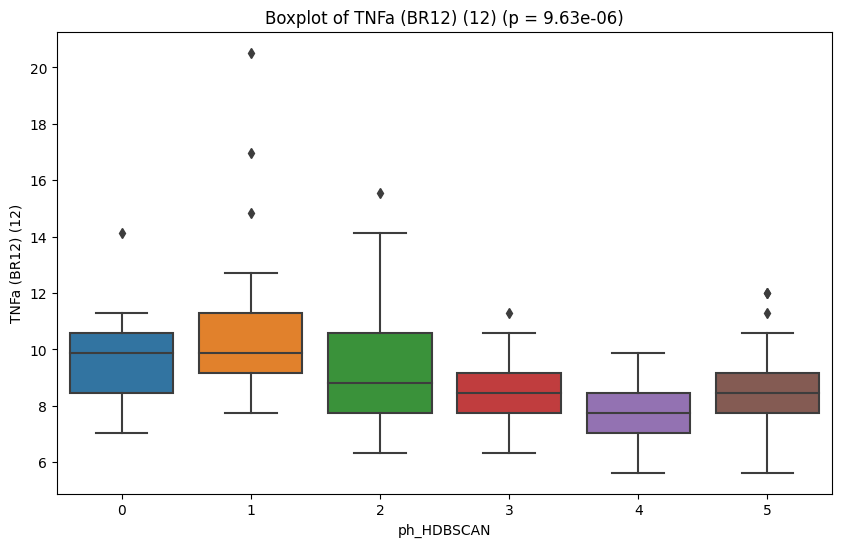

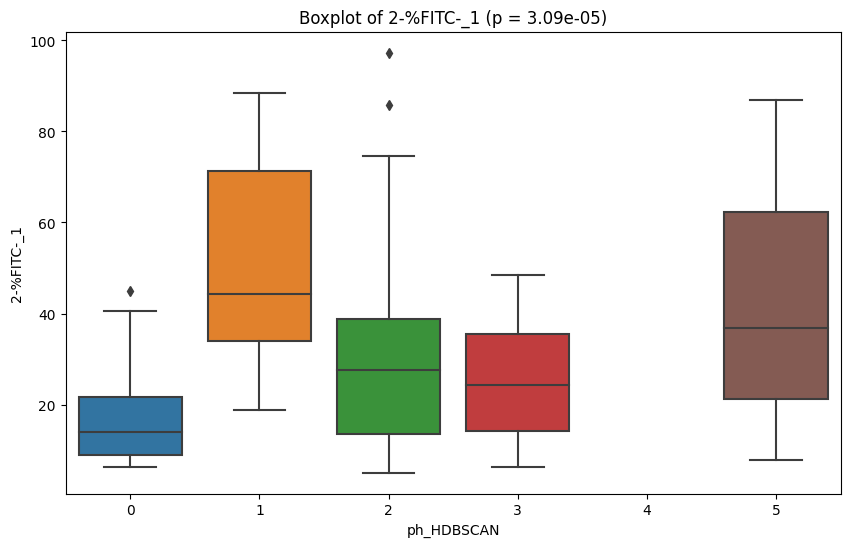

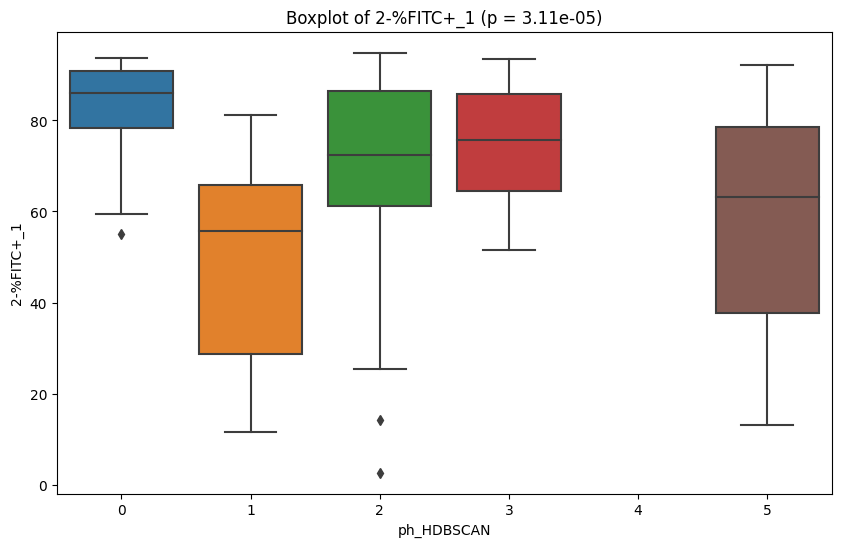

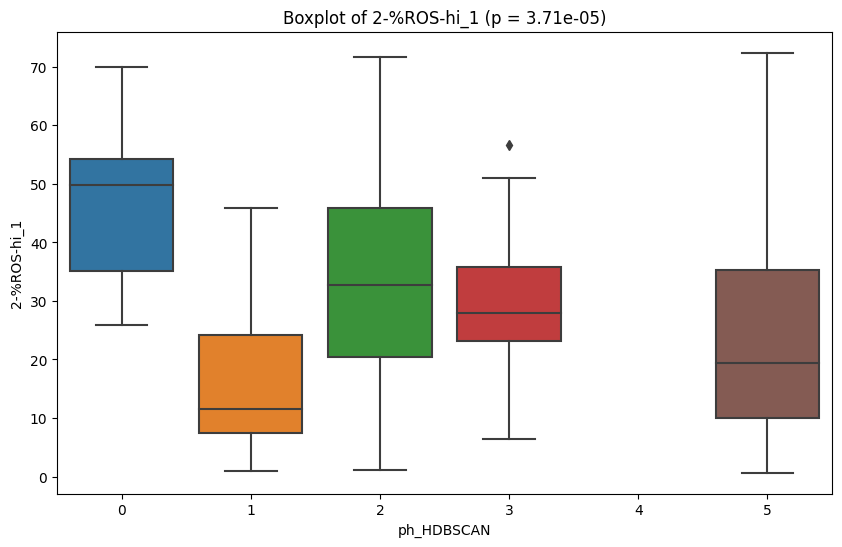

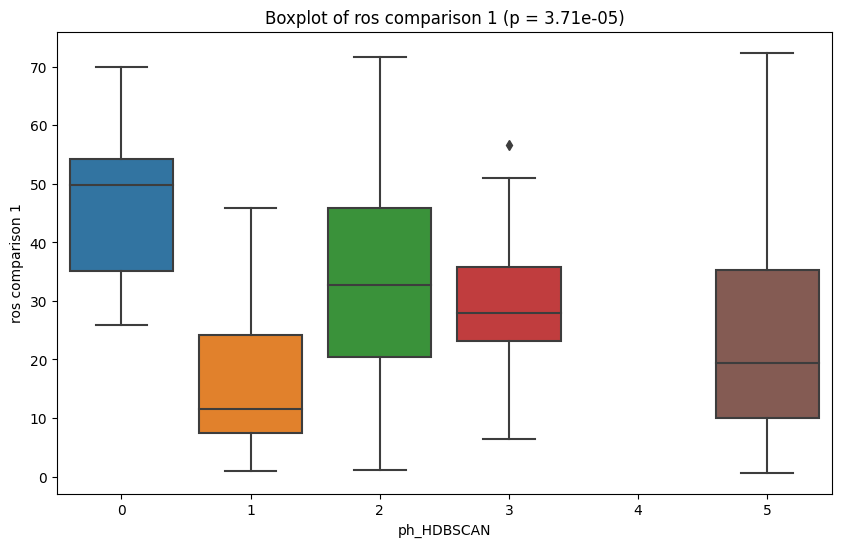

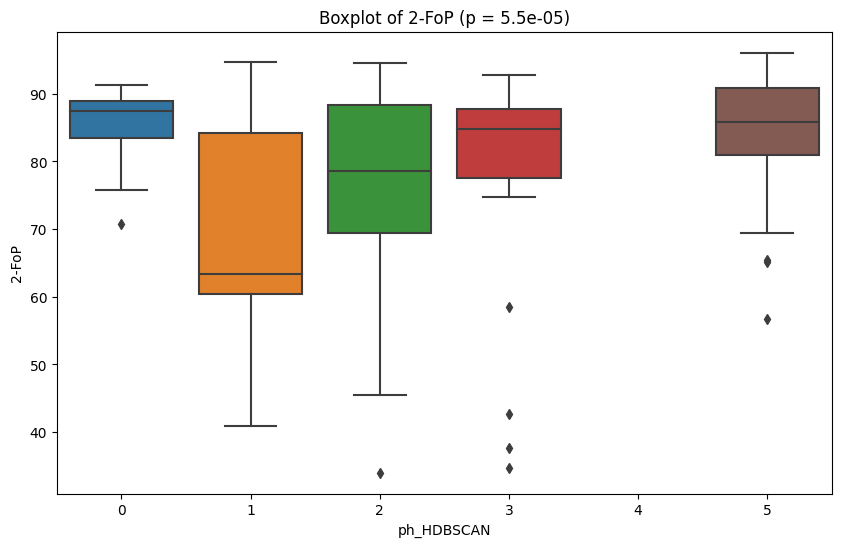

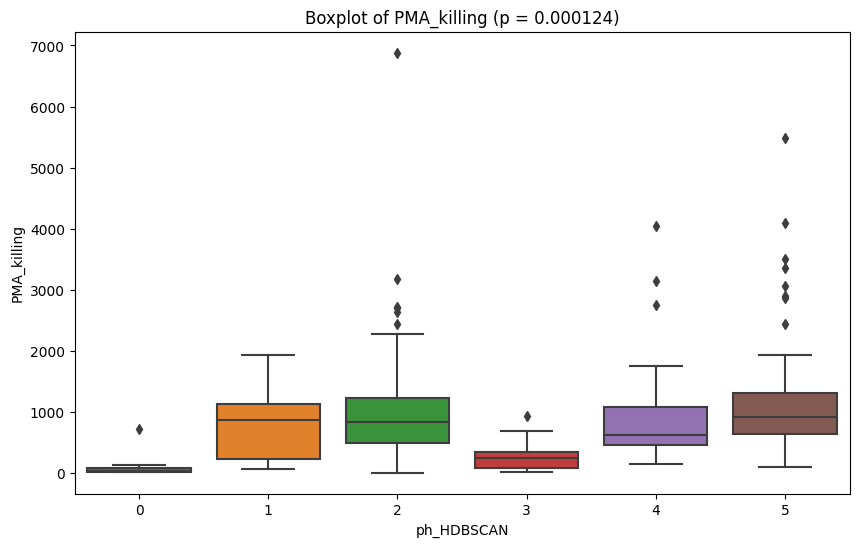

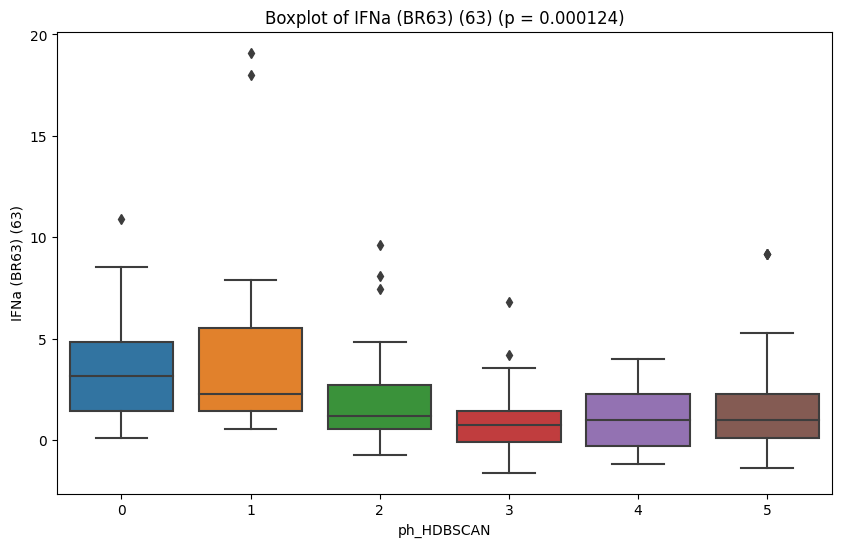

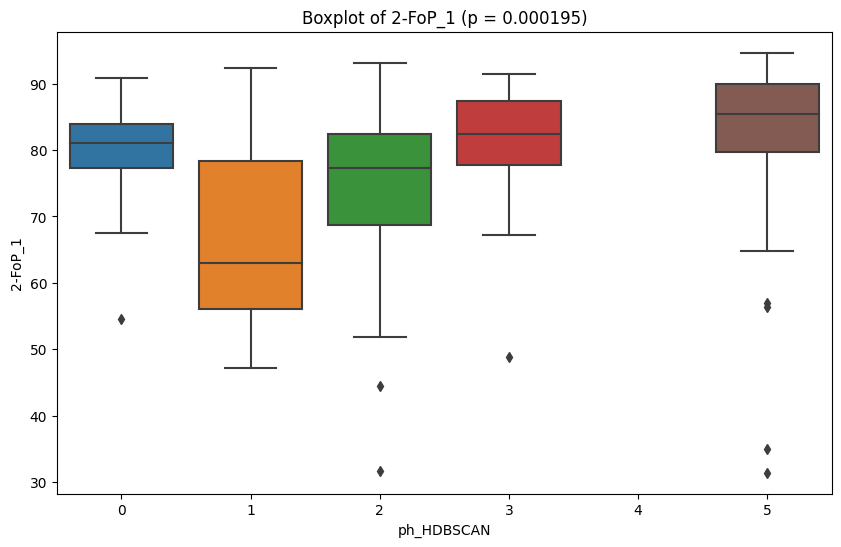

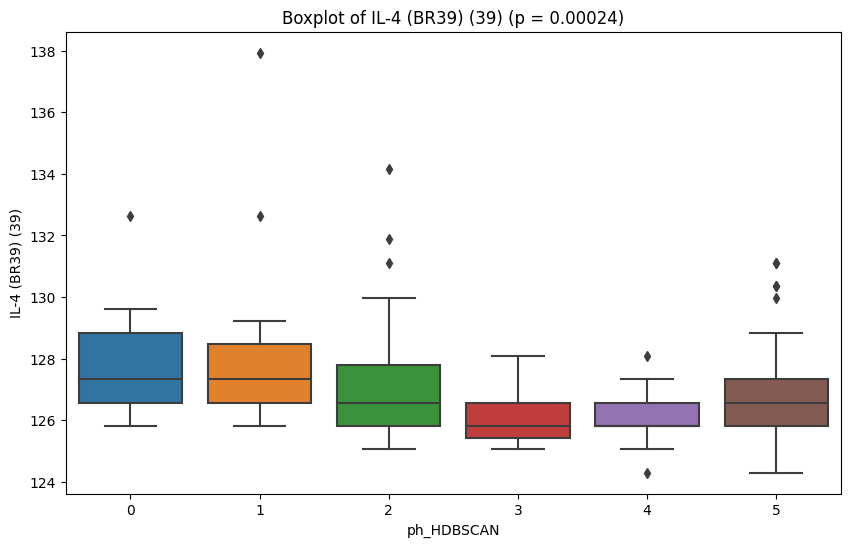

In [81]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

# Extract ph_HDBSCAN to a single variable
group_column = 'ph_HDBSCAN'

# Remove rows where group_column is NaN
master_df = master_df[~master_df[group_column].isna()]
master_df = master_df[~master_df[group_column].isna()]

# Convert categorical to numerical (if not already)
master_df[group_column] = master_df[group_column].astype('category').cat.codes

# Initialize an empty dictionary to hold ANOVA results
anova_results = {}

# Iterate over each column in the dataframe
for column in master_df.columns:

    # Only include columns that are integers or floats
    if master_df[column].dtype in ['float64', 'int64']:

        if column.startswith(("2-PMA", "2-Unstim", "1-PMA", "1-Unstim")):
            continue

        if column.startswith("umap"):
            continue

        # Remove rows where current column or target column is NaN
        column_df = master_df[[group_column, column]].dropna()

        # Prepare a list of groups for the ANOVA test
        groups = [group[1].values for group in column_df.groupby(group_column)[column]]

        # Perform the ANOVA test
        f_value, p_value = f_oneway(*groups)

        # Store the results
        anova_results[column] = {
            'f_value': f_value,
            'p_value': p_value,
        }

# Convert results to a dataframe for easier analysis
anova_df = pd.DataFrame.from_dict(anova_results, orient='index')

# Perform multiple testing correction (Bonferroni)
reject, pvals_corrected, _, _ = multipletests(anova_df['p_value'], method='bonferroni')
anova_df['p_value_corrected'] = pvals_corrected
anova_df['reject'] = reject

# Sort the dataframe by corrected p-value
anova_df = anova_df.sort_values(by='p_value_corrected')

# Get the top 20 columns with the smallest corrected p-values
top_20_columns = anova_df.head(20).index

print(top_20_columns)

# Plot boxplots for each of the top 20 columns
for column in top_20_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_column, y=column, data=master_df)
    
    # Retrieve the corrected p-value for the current column
    p_value_corrected = anova_df.loc[column, 'p_value_corrected']

    # Add corrected p-value to the title, rounding it to 3 significant figures
    plt.title(f'Boxplot of {column} (p = {p_value_corrected:.3g})')

    plt.show()
